# COVID-19 Tweet EDA

In this notebook I explore and visualize Twitter data about COVID-19, which I then use for sentiment analysis (see notebook).

## Importing and Preprocessing Data

In [35]:
import pandas as pd 
pd.set_option('display.max_colwidth', 500)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop = set(stopwords.words('english'))

nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import re
import string

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from PIL import Image

ImportError: cannot import name 'pos_tag' from 'nltk.tokenize' (/opt/conda/lib/python3.7/site-packages/nltk/tokenize/__init__.py)

In [2]:
train = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')

Since I only care abou the text data, I omit all columns that contain any meta data. Since I want to simplify this project a little bit, I only keep positive and negative tweets and drop any neutral tweets.

In [3]:
train = train[['OriginalTweet', 'Sentiment']]
test = test[['OriginalTweet', 'Sentiment']]

In [4]:
train = train[train.Sentiment != 'Neutral']
test = test[test.Sentiment != 'Neutral']

In [5]:
label2idx = {'Extremely Negative': 0, 
            'Negative': 0,
            'Positive': 1,
            'Extremely Positive': 1}

train['Sentiment'] = train['Sentiment'].replace(label2idx)
test['Sentiment'] = test['Sentiment'].replace(label2idx)

In [6]:
train.head()

,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",1
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",0
5,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",1


## Text Cleaning

In order to be able to analyze and visualize the text data, removing any urls, emojis and punctuation with regular expressions.

In [7]:
def remove_url(text):
    return re.sub(r'https?:\/\/\S+|www\.\S+', '', text)

In [8]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF' 
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [9]:
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [10]:
train['CleanedTweet'] = train['OriginalTweet'].apply(lambda tweet: remove_url(tweet))
train['CleanedTweet'] = train['OriginalTweet'].apply(lambda tweet: remove_emoji(tweet))
train['CleanedTweet'] = train['OriginalTweet'].apply(lambda tweet: remove_punctuation(tweet))

train.head(2)

,OriginalTweet,Sentiment,CleanedTweet
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak httpstcobInCA9Vp8P


Next, I tokenize the text using NLTK.

In [11]:
train['Tokenized'] = train['CleanedTweet'].apply(word_tokenize)
train.head(2)

,OriginalTweet,Sentiment,CleanedTweet,Tokenized
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,"[advice, Talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, GP, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]"
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak httpstcobInCA9Vp8P,"[Coronavirus, Australia, Woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, COVID19, outbreak, httpstcobInCA9Vp8P]"


I then turn all words into lowercase...

In [12]:
train['Lower'] = train['Tokenized'].apply(lambda tweet: [word.lower() for word in tweet])
train.head(2)

,OriginalTweet,Sentiment,CleanedTweet,Tokenized,Lower
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,"[advice, Talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, GP, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, gp, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]"
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak httpstcobInCA9Vp8P,"[Coronavirus, Australia, Woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, COVID19, outbreak, httpstcobInCA9Vp8P]","[coronavirus, australia, woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]"


...and remove all stopwords.

In [13]:
train['StopwordsRemoved'] = train['Lower'].apply(lambda tweet: [word for word in tweet if word not in stop])
train.head(2)

,OriginalTweet,Sentiment,CleanedTweet,Tokenized,Lower,StopwordsRemoved
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,"[advice, Talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, GP, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, gp, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer, chemist, gp, set, online, shopping, accounts, poss, adequate, supplies, regular, meds, order]"
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak httpstcobInCA9Vp8P,"[Coronavirus, Australia, Woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, COVID19, outbreak, httpstcobInCA9Vp8P]","[coronavirus, australia, woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]","[coronavirus, australia, woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]"


Next, I specify the token property using part-of-speech tags.

In [14]:
train['PosTags'] = train['StopwordsRemoved'].apply(nltk.tag.pos_tag)
train.head(2)

,OriginalTweet,Sentiment,CleanedTweet,Tokenized,Lower,StopwordsRemoved,PosTags
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,"[advice, Talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, GP, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, gp, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer, chemist, gp, set, online, shopping, accounts, poss, adequate, supplies, regular, meds, order]","[(advice, NN), (talk, NN), (neighbours, IN), (family, NN), (exchange, NN), (phone, NN), (numbers, NNS), (create, VBP), (contact, JJ), (list, NN), (phone, NN), (numbers, NNS), (neighbours, VBP), (schools, NNS), (employer, VBP), (chemist, JJ), (gp, NN), (set, VBN), (online, RP), (shopping, VBG), (accounts, NNS), (poss, IN), (adequate, JJ), (supplies, NNS), (regular, JJ), (meds, NNS), (order, NN)]"
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak httpstcobInCA9Vp8P,"[Coronavirus, Australia, Woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, COVID19, outbreak, httpstcobInCA9Vp8P]","[coronavirus, australia, woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]","[coronavirus, australia, woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]","[(coronavirus, NN), (australia, NNS), (woolworths, VBP), (give, VB), (elderly, JJ), (disabled, VBN), (dedicated, VBD), (shopping, NN), (hours, NNS), (amid, IN), (covid19, JJ), (outbreak, NN), (httpstcobinca9vp8p, NN)]"


In [15]:
def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

In [16]:
train['WordnetPos'] = train['PosTags'].apply(lambda tweet: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in tweet])
train.head(2)

,OriginalTweet,Sentiment,CleanedTweet,Tokenized,Lower,StopwordsRemoved,PosTags,WordnetPos
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,"[advice, Talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, GP, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, gp, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer, chemist, gp, set, online, shopping, accounts, poss, adequate, supplies, regular, meds, order]","[(advice, NN), (talk, NN), (neighbours, IN), (family, NN), (exchange, NN), (phone, NN), (numbers, NNS), (create, VBP), (contact, JJ), (list, NN), (phone, NN), (numbers, NNS), (neighbours, VBP), (schools, NNS), (employer, VBP), (chemist, JJ), (gp, NN), (set, VBN), (online, RP), (shopping, VBG), (accounts, NNS), (poss, IN), (adequate, JJ), (supplies, NNS), (regular, JJ), (meds, NNS), (order, NN)]","[(advice, n), (talk, n), (neighbours, n), (family, n), (exchange, n), (phone, n), (numbers, n), (create, v), (contact, a), (list, n), (phone, n), (numbers, n), (neighbours, v), (schools, n), (employer, v), (chemist, a), (gp, n), (set, v), (online, r), (shopping, v), (accounts, n), (poss, n), (adequate, a), (supplies, n), (regular, a), (meds, n), (order, n)]"
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak httpstcobInCA9Vp8P,"[Coronavirus, Australia, Woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, COVID19, outbreak, httpstcobInCA9Vp8P]","[coronavirus, australia, woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]","[coronavirus, australia, woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]","[(coronavirus, NN), (australia, NNS), (woolworths, VBP), (give, VB), (elderly, JJ), (disabled, VBN), (dedicated, VBD), (shopping, NN), (hours, NNS), (amid, IN), (covid19, JJ), (outbreak, NN), (httpstcobinca9vp8p, NN)]","[(coronavirus, n), (australia, n), (woolworths, v), (give, v), (elderly, a), (disabled, v), (dedicated, v), (shopping, n), (hours, n), (amid, n), (covid19, a), (outbreak, n), (httpstcobinca9vp8p, n)]"


Lastly, I lemmatize the text.

In [17]:
wnl = WordNetLemmatizer()

train['Lemmatized'] = train['WordnetPos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
train['Lemmatized'] = train['Lemmatized'].apply(lambda x: [word for word in x if word not in stop])

train.head(2)

,OriginalTweet,Sentiment,CleanedTweet,Tokenized,Lower,StopwordsRemoved,PosTags,WordnetPos,Lemmatized
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,"[advice, Talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, GP, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, to, your, neighbours, family, to, exchange, phone, numbers, create, contact, list, with, phone, numbers, of, neighbours, schools, employer, chemist, gp, set, up, online, shopping, accounts, if, poss, adequate, supplies, of, regular, meds, but, not, over, order]","[advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer, chemist, gp, set, online, shopping, accounts, poss, adequate, supplies, regular, meds, order]","[(advice, NN), (talk, NN), (neighbours, IN), (family, NN), (exchange, NN), (phone, NN), (numbers, NNS), (create, VBP), (contact, JJ), (list, NN), (phone, NN), (numbers, NNS), (neighbours, VBP), (schools, NNS), (employer, VBP), (chemist, JJ), (gp, NN), (set, VBN), (online, RP), (shopping, VBG), (accounts, NNS), (poss, IN), (adequate, JJ), (supplies, NNS), (regular, JJ), (meds, NNS), (order, NN)]","[(advice, n), (talk, n), (neighbours, n), (family, n), (exchange, n), (phone, n), (numbers, n), (create, v), (contact, a), (list, n), (phone, n), (numbers, n), (neighbours, v), (schools, n), (employer, v), (chemist, a), (gp, n), (set, v), (online, r), (shopping, v), (accounts, n), (poss, n), (adequate, a), (supplies, n), (regular, a), (meds, n), (order, n)]","[advice, talk, neighbour, family, exchange, phone, number, create, contact, list, phone, number, neighbour, school, employer, chemist, gp, set, online, shop, account, po, adequate, supply, regular, med, order]"
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak httpstcobInCA9Vp8P,"[Coronavirus, Australia, Woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, COVID19, outbreak, httpstcobInCA9Vp8P]","[coronavirus, australia, woolworths, to, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]","[coronavirus, australia, woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, covid19, outbreak, httpstcobinca9vp8p]","[(coronavirus, NN), (australia, NNS), (woolworths, VBP), (give, VB), (elderly, JJ), (disabled, VBN), (dedicated, VBD), (shopping, NN), (hours, NNS), (amid, IN), (covid19, JJ), (outbreak, NN), (httpstcobinca9vp8p, NN)]","[(coronavirus, n), (australia, n), (woolworths, v), (give, v), (elderly, a), (disabled, v), (dedicated, v), (shopping, n), (hours, n), (amid, n), (covid19, a), (outbreak, n), (httpstcobinca9vp8p, n)]","[coronavirus, australia, woolworths, give, elderly, disable, dedicate, shopping, hour, amid, covid19, outbreak, httpstcobinca9vp8p]"


## Visualization

### What is the number of positive and negative tweets in the training set?

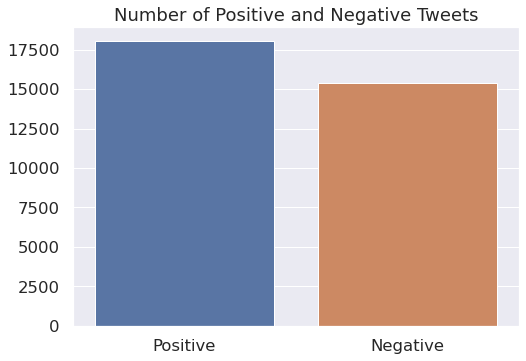

In [19]:
ax = sns.barplot(np.arange(0, 2), train['Sentiment'].value_counts().to_numpy())
ax.set_xticklabels(['Positive', 'Negative'])
plt.title('Number of Positive and Negative Tweets');

In [23]:
distr_neg = [tweet.split() for tweet in train['OriginalTweet']] # split negative tweets into words
len_distr_neg = [len(tweet) for tweet in distr_neg] # get length of each tweet
distr_pos = [tweet.split() for tweet in train[train.Sentiment == 1]['OriginalTweet']] # split positive tweets into words
len_distr_pos = [len(tweet) for tweet in distr_pos] # get length of each tweet

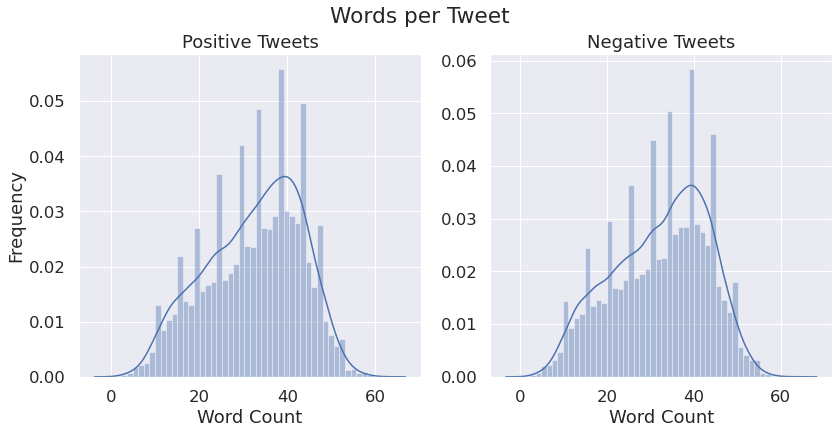

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(len_distr_pos, ax=axes[0])
sns.distplot(len_distr_neg, ax=axes[1])
axes[0].set_title('Positive Tweets')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[1].set_title('Negative Tweets')
axes[1].set_xlabel('Word Count')
fig.suptitle('Words per Tweet', va='baseline')
plt.tight_layout()
plt.show();

### What is the distribution concerning the word length?

In [26]:
len_char_pos = []
for tweet in distr_pos:
    len_char_pos.append([len(i) for i in tweet]) # get length of each word in each positive tweet
len_char_pos_flat = [item for sublist in len_char_pos for item in sublist]

len_char_neg = []
for tweet in distr_neg:
    len_char_neg.append([len(i) for i in tweet]) # get length ofe each word in each negative tweet
len_char_neg_flat = [item for sublist in len_char_neg for item in sublist]

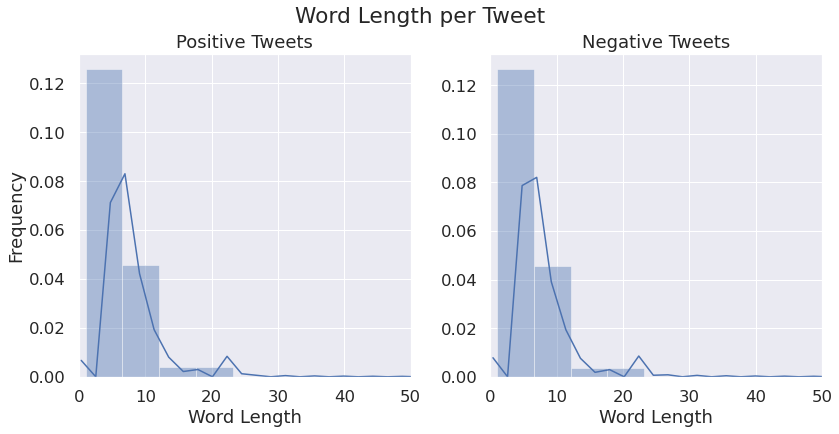

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(len_char_pos_flat, ax=axes[0])
sns.distplot(len_char_neg_flat, ax=axes[1])
axes[0].set_title('Positive Tweets')
axes[0].set_xlabel('Word Length')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 50)
axes[1].set_title('Negative Tweets')
axes[1].set_xlabel('Word Length')
axes[1].set_xlim(0, 50)
fig.suptitle('Word Length per Tweet', va='baseline')
plt.tight_layout()
plt.show();

### What are the most common unigrams?

In [28]:
lemm_pos = train[train.Sentiment == 1]['Lemmatized'].to_list()
lemm_pos_flat = [item for sublist in lemm_pos for item in sublist] # put all lemmata into a list
counter_pos = Counter(lemm_pos_flat) # get the frequency of each lemma
most_pos = counter_pos.most_common()

In [29]:
lemm_neg = train[train.Sentiment == 0]['Lemmatized'].to_list() # same for negative tweets
lemm_neg_flat = [item for sublist in lemm_neg for item in sublist]
counter_neg = Counter(lemm_neg_flat)
most_neg = counter_neg.most_common()

In [30]:
words_neg = []
count_neg = []
for i in range(20):
    words_neg.append(most_neg[i][0]) # get the 20 most frequent lemmata...
    count_neg.append(most_neg[i][1]) # ... and their frequency

words_pos = []
count_pos = []
for i in range(20):
    words_pos.append(most_pos[i][0])
    count_pos.append(most_pos[i][1])

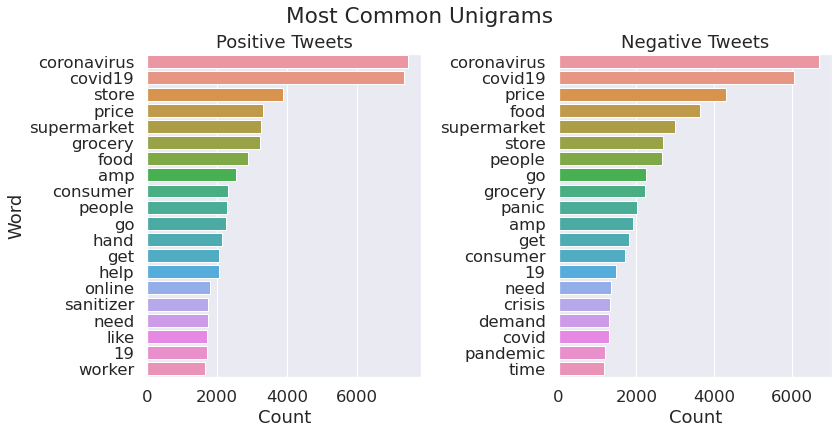

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(count_pos, words_pos, ax=axes[0])
sns.barplot(count_neg, words_neg, ax=axes[1])
axes[0].set_title('Positive Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_title('Negative Tweets')
axes[1].set_xlabel('Count')
fig.suptitle('Most Common Unigrams', va='baseline')
plt.tight_layout()
plt.show();

In [32]:
def plot_wordcloud(text, title, title_size):
    
    mostcommon = FreqDist(text).most_common(140)
    
    wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    stopwords=set(STOPWORDS),
    max_words=150,
    scale=3).generate(str(mostcommon))
    
    fig = plt.figure(figsize=(18,18), facecolor='white')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontdict={'size': title_size})
    plt.tight_layout()
    plt.show()

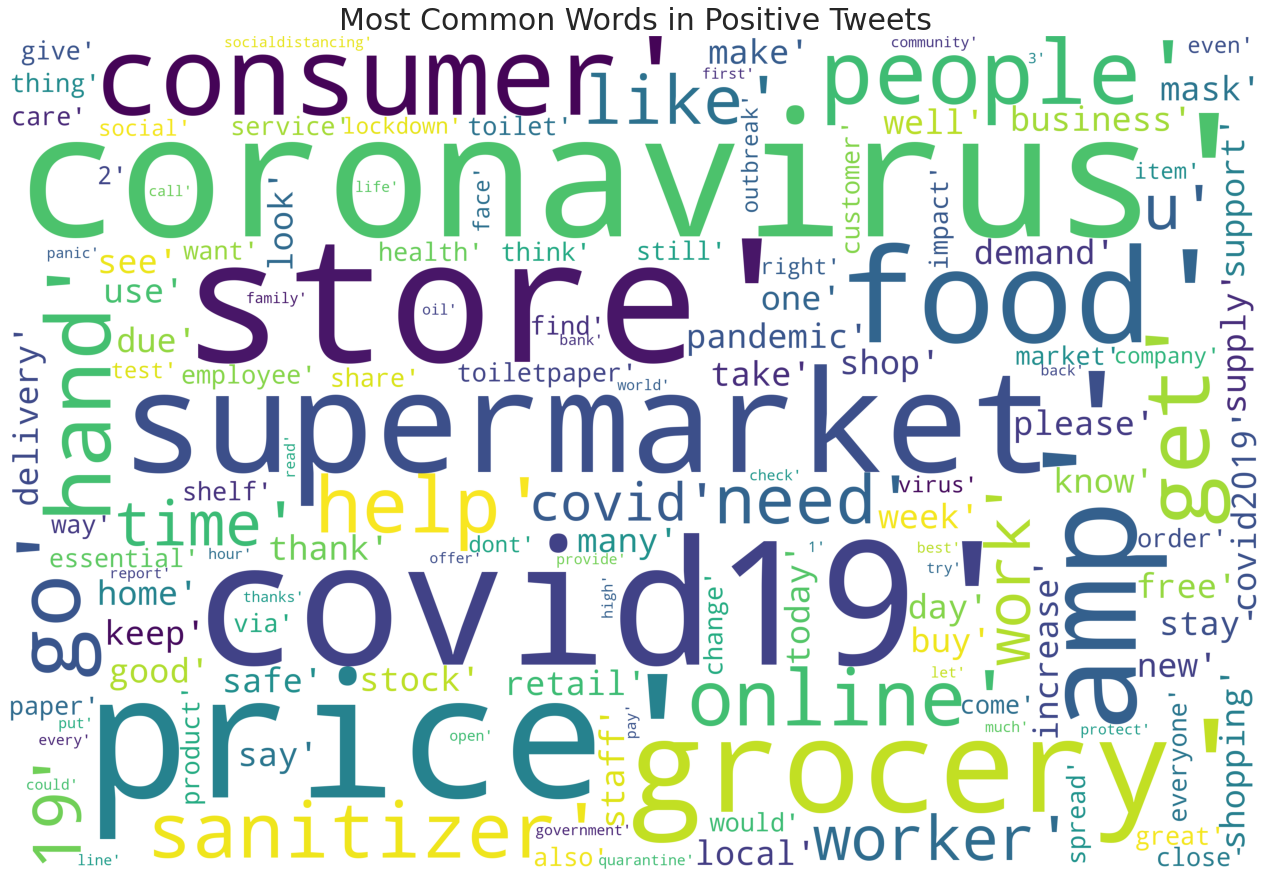

In [33]:
plot_wordcloud(lemm_pos_flat,
               'Most Common Words in Positive Tweets',
               title_size=30)

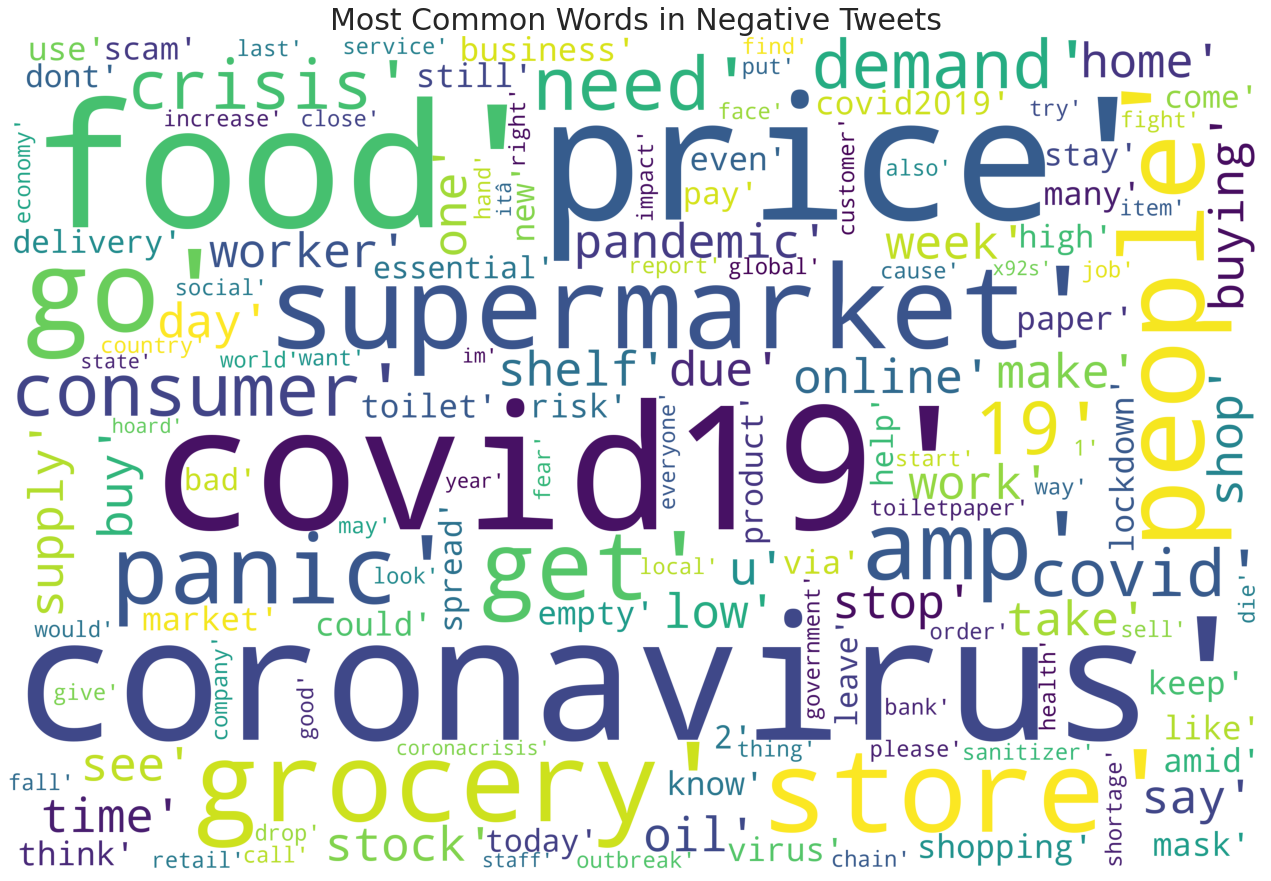

In [34]:
plot_wordcloud(lemm_neg_flat,
               'Most Common Words in Negative Tweets',
               title_size=30)